# Image segmentation with a U-Net-like architecture

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2019/03/20<br>
**Last modified:** 2020/04/20<br>
**Description:** Image segmentation model trained from scratch on the Plastic Debris dataset.

## Download the data

## Prepare paths of input images and target segmentation masks

In [28]:
import os

img_size = (160, 160)
num_classes = 3
batch_size = 8

DATA_DIR = './drive/MyDrive/ocenic (1)/'

input_img_paths = os.path.join(DATA_DIR, 'train')
target_img_paths = os.path.join(DATA_DIR, 'trainannon/mask')

x_valid_dir = os.path.join(DATA_DIR, 'test')
y_valid_dir = os.path.join(DATA_DIR, 'testannon/mask')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannon/mask')

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
from pycocotools.coco import COCO
import os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

img_dir = '/content/drive/MyDrive/ocenic (1)/train'
coco = COCO('/content/drive/MyDrive/ocenic (1)/trainannon/anon.json')
with open('/content/drive/MyDrive/ocenic (1)/trainannon/anon.json', 'r') as l:
  m = json.load(l)

for i in m['images']:
  img_id = i['id']
  img = coco.imgs[img_id]
  image = np.array(Image.open(os.path.join(img_dir, img['file_name'])))
  # generate annotations on image

  plt.imshow(image)
  cat_ids = coco.getCatIds()
  anns_ids = coco.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
  anns = coco.loadAnns(anns_ids)
  coco.showAnns(anns)

  # generate and save mask
  mask = coco.annToMask(anns[0])
  for i in range(len(anns)):
    mask += coco.annToMask(anns[i])
  plt.imshow(mask)
  plt.savefig("/content/drive/MyDrive/ocenic (1)/trainannon/mask/{}".format(img_id), bbox_inches='tight')
  plt.close()

In [31]:
import os

input_dir = DATA_DIR+"train/"
target_dir = DATA_DIR+"trainannon/mask/"
img_size = (160, 160)
num_classes = 3


input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 16
./drive/MyDrive/ocenic (1)/train/10.jpg | ./drive/MyDrive/ocenic (1)/trainannon/mask/1.png
./drive/MyDrive/ocenic (1)/train/11.jpg | ./drive/MyDrive/ocenic (1)/trainannon/mask/10.png
./drive/MyDrive/ocenic (1)/train/12.jpg | ./drive/MyDrive/ocenic (1)/trainannon/mask/11.png
./drive/MyDrive/ocenic (1)/train/13.jpg | ./drive/MyDrive/ocenic (1)/trainannon/mask/12.png
./drive/MyDrive/ocenic (1)/train/15.jpg | ./drive/MyDrive/ocenic (1)/trainannon/mask/13.png
./drive/MyDrive/ocenic (1)/train/16.jpg | ./drive/MyDrive/ocenic (1)/trainannon/mask/14.png
./drive/MyDrive/ocenic (1)/train/17.jpg | ./drive/MyDrive/ocenic (1)/trainannon/mask/15.png
./drive/MyDrive/ocenic (1)/train/24.jpg | ./drive/MyDrive/ocenic (1)/trainannon/mask/16.png
./drive/MyDrive/ocenic (1)/train/25.jpg | ./drive/MyDrive/ocenic (1)/trainannon/mask/2.png
./drive/MyDrive/ocenic (1)/train/26.jpg | ./drive/MyDrive/ocenic (1)/trainannon/mask/3.png


## What does one input image and corresponding segmentation mask look like?

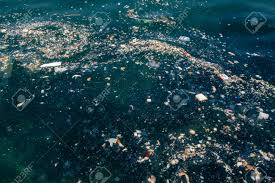

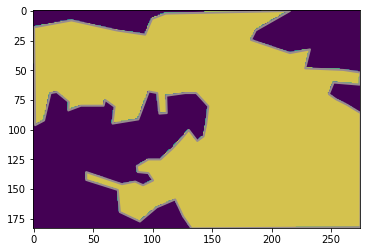

In [32]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

# Display input image #7
display(Image(filename=input_img_paths[0]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[0]))
display(img)

## Prepare `Sequence` class to load & vectorize batches of data

In [33]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class PlasticDebris(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            y[j] -= 1
        return x, y


## Prepare U-Net Xception-style model

In [34]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 80, 80, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

## Set aside a validation split

In [42]:
import random

# Split our img paths into a training and a validation set
val_samples = 3
batch_size = 3
random.Random(3).shuffle(input_img_paths)
random.Random(3).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = PlasticDebris(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = PlasticDebris(batch_size, img_size, val_input_img_paths, val_target_img_paths)

## Train the model

In [43]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="rmsprop", loss="mean_squared_error")

callbacks = [
    keras.callbacks.ModelCheckpoint("plastic_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/15
4/4 [==============================] - 9s 1s/step - loss: 23947.6406 - val_loss: 31402.6094
Epoch 2/15


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


4/4 [==============================] - 4s 931ms/step - loss: 23947.6465 - val_loss: 31402.6094
Epoch 3/15
4/4 [==============================] - 4s 965ms/step - loss: 23947.6543 - val_loss: 31402.6094
Epoch 4/15
4/4 [==============================] - 4s 916ms/step - loss: 23947.6504 - val_loss: 31402.5996
Epoch 5/15
4/4 [==============================] - 4s 951ms/step - loss: 23947.6484 - val_loss: 31402.5859
Epoch 6/15
4/4 [==============================] - 4s 944ms/step - loss: 23947.6406 - val_loss: 31402.6074
Epoch 7/15
4/4 [==============================] - 4s 954ms/step - loss: 23947.6465 - val_loss: 31402.5996
Epoch 8/15
4/4 [==============================] - 4s 944ms/step - loss: 23947.6270 - val_loss: 31402.6074
Epoch 9/15
4/4 [==============================] - 4s 945ms/step - loss: 23947.6113 - val_loss: 31402.6094
Epoch 10/15
4/4 [==============================] - 4s 969ms/step - loss: 23947.5996 - val_loss: 31402.6094
Epoch 11/15
4/4 [==============================] - 4s 93

## Visualize predictions

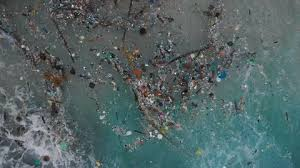

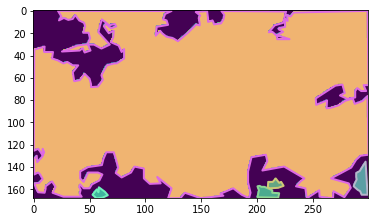

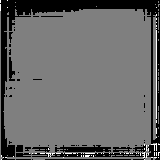

In [46]:
# Generate predictions for all images in the validation set

val_gen = PlasticDebris(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 2

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.